## Entendimento do problema

Dentro da empresa existe uma equipe que é responsável por definir as características de produtos que vão ser construídos. Para uma categoria de liquidificadores, por exemplo, essa equipe fica responsável por definir a cor, volume do copo, material do copo ou mesmo se vai ter um filtro para suco de frutas. Para **definir as características** das diferentes categorias de produtos, a equipe procura **entender quando o cliente se interessa por um produto**. É nesse ponto que o time do Labs é chamado. 

O seu objetivo principal é desenvolver um modelo que consiga classificar o produto entre "interessante" e "não interessante" dados os atributos do mesmo. Além disso, é desejável que você também consiga **indicar quais são os atributos e respectivos valores que mais impulsionam o interesse do cliente**.

O conjunto de dados possui os atributos de cada produto de uma categoria de panelas e se houve ou não interesse do cliente ao visualizar o produto no site. Cada linha é o registro da visualização de um cliente em determinado momento.

## Carregamento e exame inicial da base

In [1]:
import pandas as pd
dataset = pd.read_csv('problem1_dataset.csv')
dataset.head()

,ITEM_ID,ALTURA,CAPACIDADE_(L),COMPOSICAO,COR,FORMATO,LARGURA,MARCA,PARA_LAVA_LOUCAS,PARA_MICRO_ONDAS,PESO,PROFUNDIDADE,TEMPO_GARANTIA,TEM_FERRO_FUNDIDO,TEM_GRELHA,TEM_TAMPA,TIPO_PRODUTO,TIPO_WOK,SESSION_ID,ITEM_PRICE,INTERESTED
0,264220456,30.5,NaN,ALUMINIO,VINHO,NaN,14.0,LA CUISINE,NaN,NaN,NaN,50.0,3.0,NAO,SIM,1.0,PANELA,NAO,86.709770,199.990000,0.0
1,238630912,22.0,NaN,ALUMINIO,COLORIDO,NaN,24.0,TRAMONTINA,No,no,150.0,40.0,12.0,NAO,NAO,1.0,PIPOQUEIRA,NAO,73.156401,105.112581,0.0
2,218228122,24.0,NaN,INOX,INOX,NaN,20.0,LA CUISINE,Yes,no,190.0,20.0,3.0,NAO,NAO,1.0,ESPAGUETEIRA,NAO,952.331024,139.990000,0.0
3,253661510,49.5,6.0,ALUMINIO,VERMELHO,REDONDO,41.5,TRAMONTINA,Yes,NaN,120.0,47.0,NaN,NAO,NAO,1.0,PIPOQUEIRA,NAO,637.759106,103.293333,1.0
4,253661510,49.5,6.0,ALUMINIO,VERMELHO,REDONDO,41.5,TRAMONTINA,Yes,NaN,120.0,47.0,NaN,NAO,NAO,1.0,PIPOQUEIRA,NAO,478.531428,103.330242,0.0


Tamanho da base

In [2]:
len(dataset)

89189

Avaliando missings da base

In [3]:
dataset.isnull().sum()

ITEM_ID                  0
ALTURA                4614
CAPACIDADE_(L)       51262
COMPOSICAO           11522
COR                   4841
FORMATO              44750
LARGURA               4615
MARCA                  149
PARA_LAVA_LOUCAS     37615
PARA_MICRO_ONDAS     46369
PESO                 40371
PROFUNDIDADE          4615
TEMPO_GARANTIA       28467
TEM_FERRO_FUNDIDO        1
TEM_GRELHA               1
TEM_TAMPA                1
TIPO_PRODUTO             1
TIPO_WOK                 1
SESSION_ID            1000
ITEM_PRICE            6534
INTERESTED               1
dtype: int64

Definindo colunas de IDS, numéricas e categóricas

In [2]:
id_columns = ['ITEM_ID','SESSION_ID']
cat_columns = dataset.select_dtypes('object').columns
num_columns = dataset.select_dtypes(exclude=['object']).drop(id_columns, axis = 1).columns

Avaliando estatísticas gerais das variáveis numéricas

In [5]:
stats = dataset.drop(id_columns, axis=1).describe()
stats

,ALTURA,CAPACIDADE_(L),LARGURA,PESO,PROFUNDIDADE,TEMPO_GARANTIA,TEM_TAMPA,ITEM_PRICE,INTERESTED
count,84575.000000,37927.000000,84574.000000,48818.000000,84574.000000,60722.000000,89188.000000,82655.000000,89188.000000
mean,30.639156,4.237928,27.885013,321.861013,34.778490,13.739682,0.442167,128.115079,0.085897
std,14.863511,1.695356,10.529214,1839.352108,15.209001,43.171095,0.496647,140.995076,0.280214
min,2.000000,0.045000,4.500000,0.619000,2.500000,1.000000,0.000000,4.900000,0.000000
25%,19.000000,3.100000,20.000000,120.000000,19.800000,3.000000,0.000000,74.990000,0.000000
50%,30.500000,4.500000,27.800000,160.000000,38.500000,6.000000,0.000000,104.275714,0.000000
75%,42.700000,6.000000,35.000000,190.000000,47.000000,12.000000,1.000000,144.990000,0.000000
max,84.000000,11.000000,91.000000,44400.000000,148.000000,300.000000,1.000000,2274.990000,1.000000


Levantando o número de Outliers (limite superior) das variáveis numéricas

In [6]:
num_outlier = []

for i in num_columns:
  p75 = stats.iloc[6][i]
  p25 = stats.iloc[4][i]
  iqr = p75 - p25
  higher_outlier = p75 + (1.5 * iqr)
  count_outlier = (dataset[i] > higher_outlier).sum()
  num_outlier.append(count_outlier)

print(num_columns)
print(num_outlier)

Index(['ALTURA', 'CAPACIDADE_(L)', 'LARGURA', 'PESO', 'PROFUNDIDADE',
       'TEMPO_GARANTIA', 'TEM_TAMPA', 'ITEM_PRICE', 'INTERESTED'],
      dtype='object')
[342, 191, 406, 9864, 351, 1457, 0, 3901, 7661]


Preenchimento de missings para as variáveis numéricas será através da mediana e para as categóricas a moda

In [3]:
for column in dataset.columns:
  if dataset[column].dtype == 'object':
    dataset[column].fillna(dataset[column].mode()[0], inplace = True)
  elif dataset[column].dtype != 'object':
    dataset[column].fillna(dataset[column].median(), inplace = True)

In [4]:
#conferência
dataset.isnull().sum()

ITEM_ID              0
ALTURA               0
CAPACIDADE_(L)       0
COMPOSICAO           0
COR                  0
FORMATO              0
LARGURA              0
MARCA                0
PARA_LAVA_LOUCAS     0
PARA_MICRO_ONDAS     0
PESO                 0
PROFUNDIDADE         0
TEMPO_GARANTIA       0
TEM_FERRO_FUNDIDO    0
TEM_GRELHA           0
TEM_TAMPA            0
TIPO_PRODUTO         0
TIPO_WOK             0
SESSION_ID           0
ITEM_PRICE           0
INTERESTED           0
dtype: int64

Checando por variância nula nas variáveis categoricas

In [28]:
for column in cat_columns:
  print(column)
  print(dataset[column].value_counts())
  print('_________')

COMPOSICAO
ALUMINIO         88467
INOX             26089
CERAMICA          1227
PORCELANA           88
ACO ESMALTADO       88
Name: COMPOSICAO, dtype: int64
_________
COR
INOX         28621
PRETO        19748
VERMELHO     19593
CEREJA       15245
COLORIDO      5640
GRAFITE       5109
VINHO         4159
GOIABA        3377
AMARELO       2756
PRATA         2451
LARANJA       1548
COBRE         1470
BERINGELA     1184
AZUL          1151
VERDE          853
CHOCOLATE      738
TURQUESA       693
ROXO           549
MARROM         529
BRANCO         248
ROSA           206
CINZA           72
FENDI           18
ACACIA           1
Name: COR, dtype: int64
_________
FORMATO
REDONDO       109438
QUADRADO        2484
FRIGIDEIRA      2189
OVAL            1166
RETANGULAR       682
Name: FORMATO, dtype: int64
_________
MARCA
TRAMONTINA                      47123
LA CUISINE                      20790
PANELA MINEIRA                   8405
BRINOX                           5167
VEC                           

Verificada a necessidade de recodificação para o campo "PARA_LAVA_LOUCA"

In [5]:
dataset['PARA_LAVA_LOUCAS'].replace('NAO','No',inplace=True)
dataset['PARA_LAVA_LOUCAS'].value_counts()

Yes    111984
No      21807
Name: PARA_LAVA_LOUCAS, dtype: int64

Verificando balanceamento da variável de interesse

In [6]:
dataset['INTERESTED'].value_counts()

0.0    122285
1.0     11506
Name: INTERESTED, dtype: int64

Parecer inicial:

*   Necessidade de oversampling para lidar com desbalanceamento
*   É necessário um modelo classificador que lide bem com outliers, que é um problema detectado nas variáveis numéricas
*   Também algumas variáveis categoricas podem precisar de oversampling, especialmente: TIPO_PRODUTO, MARCA e COR
* Optou-se por não realizar redução de dimensionalidade (PCA) pois a base dispõe de poucas variáveis numéricas




## Análise exploratória de dados

Correlação vars numéricas

In [7]:
corr_matrix = dataset.drop(id_columns, axis=1).corr()
corr_matrix.head(10)

,ALTURA,CAPACIDADE_(L),LARGURA,PESO,PROFUNDIDADE,TEMPO_GARANTIA,TEM_TAMPA,ITEM_PRICE,INTERESTED
ALTURA,1.000000,0.297130,0.514292,-0.012732,0.077536,0.001430,0.078443,0.099980,0.014131
CAPACIDADE_(L),0.297130,1.000000,0.218060,-0.019087,0.145557,-0.150323,0.281708,0.082119,0.004024
LARGURA,0.514292,0.218060,1.000000,0.017123,0.144336,0.017789,-0.007976,0.176237,-0.011925
PESO,-0.012732,-0.019087,0.017123,1.000000,-0.036462,-0.003419,0.009741,0.010573,-0.006738
PROFUNDIDADE,0.077536,0.145557,0.144336,-0.036462,1.000000,-0.028234,0.293994,0.291111,-0.007609
TEMPO_GARANTIA,0.001430,-0.150323,0.017789,-0.003419,-0.028234,1.000000,-0.132906,0.037567,-0.000740
TEM_TAMPA,0.078443,0.281708,-0.007976,0.009741,0.293994,-0.132906,1.000000,0.044682,0.022345
ITEM_PRICE,0.099980,0.082119,0.176237,0.010573,0.291111,0.037567,0.044682,1.000000,-0.023812
INTERESTED,0.014131,0.004024,-0.011925,-0.006738,-0.007609,-0.000740,0.022345,-0.023812,1.000000


A correlação entre variáveis numéricas com valor mais relevante é entre altura e largura (51%). Não foi detectado relacionamentos que possam ser fatores de confusão na construção de um modelo.

**Avaliando a média das variáveis numéricas vs variável de interesse**

In [8]:
avg_num = dataset.drop(id_columns, axis=1).groupby('INTERESTED', as_index=False).mean()
avg_num.head()

,INTERESTED,ALTURA,CAPACIDADE_(L),LARGURA,PESO,PROFUNDIDADE,TEMPO_GARANTIA,TEM_TAMPA,ITEM_PRICE
0,0.0,30.540649,4.387297,27.931405,246.857095,35.008578,11.383473,0.436538,127.102147
1,1.0,31.270585,4.403343,27.496232,215.737384,34.606349,11.287763,0.476099,115.827115


Como esperado a média de preço é bem inferior nos itens que despertaram interessse

Características de tamanho do produto também não parecem ter muita distinção - podemos criar uma classificação categórica para avaliar melhor

Tem tampa - é variável binária - a investigar

Bibliotecas gráficas

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Análise da Feature TEM_TAMPA

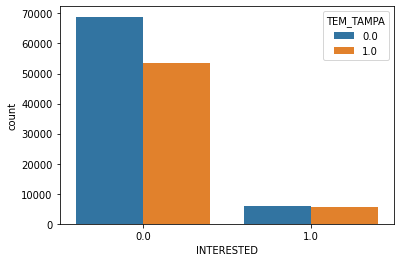

In [10]:
sns.countplot(x='INTERESTED', hue='TEM_TAMPA', data=dataset)

Entre os clientes interessados a proporção de panelas com tampa é próxima a 50%. Nos não interessados a proporção é menor. Essa análise sugere um interesse maior em produtos com tampa.

## Continuação AED - Categóricas
Avaliação das demais variáveis categorias

<Figure size 432x288 with 0 Axes>

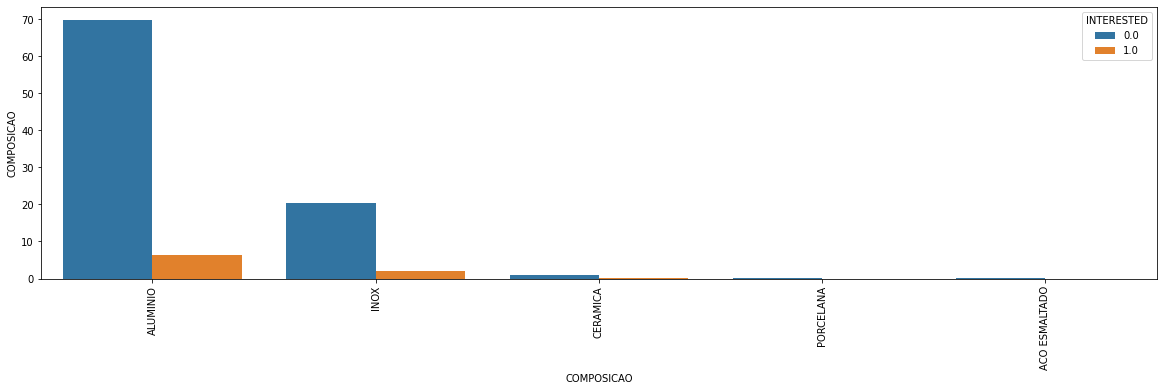

<Figure size 432x288 with 0 Axes>

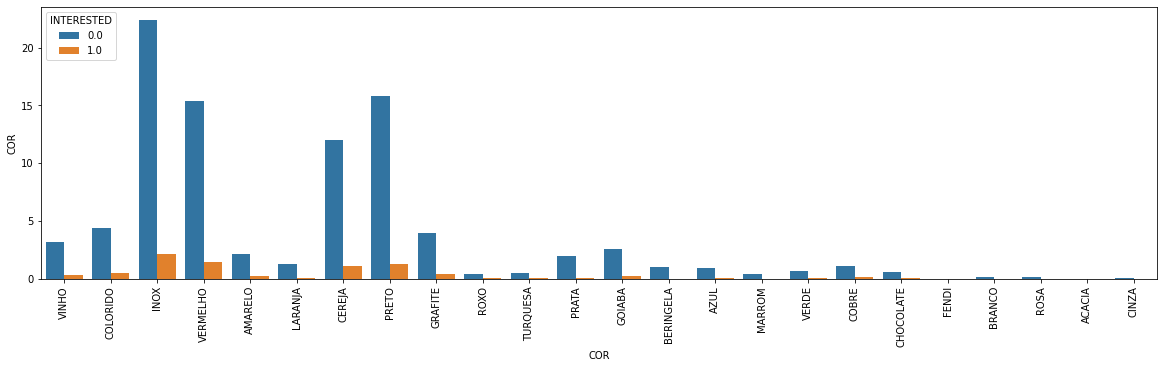

<Figure size 432x288 with 0 Axes>

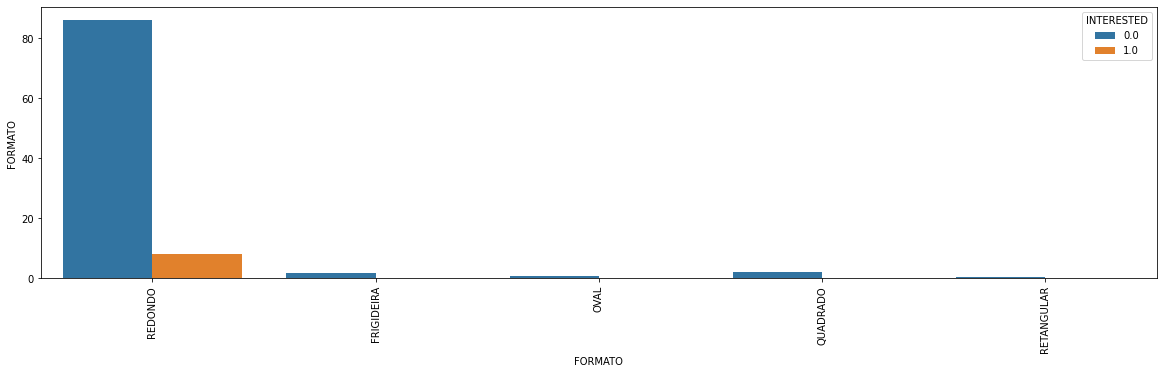

<Figure size 432x288 with 0 Axes>

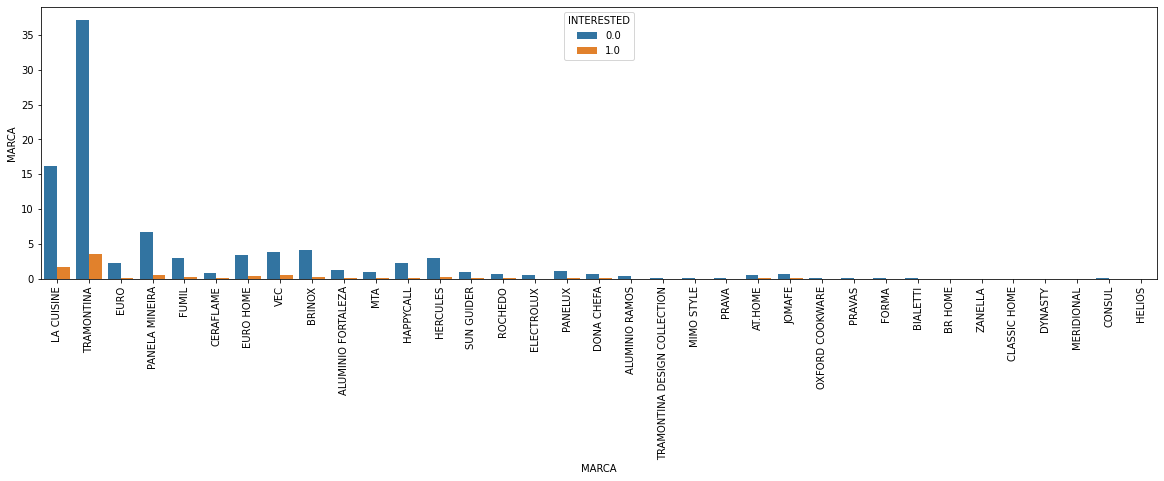

<Figure size 432x288 with 0 Axes>

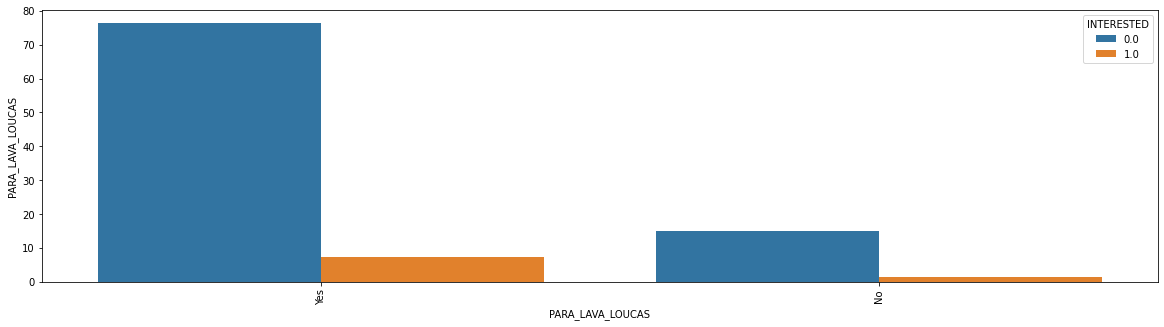

<Figure size 432x288 with 0 Axes>

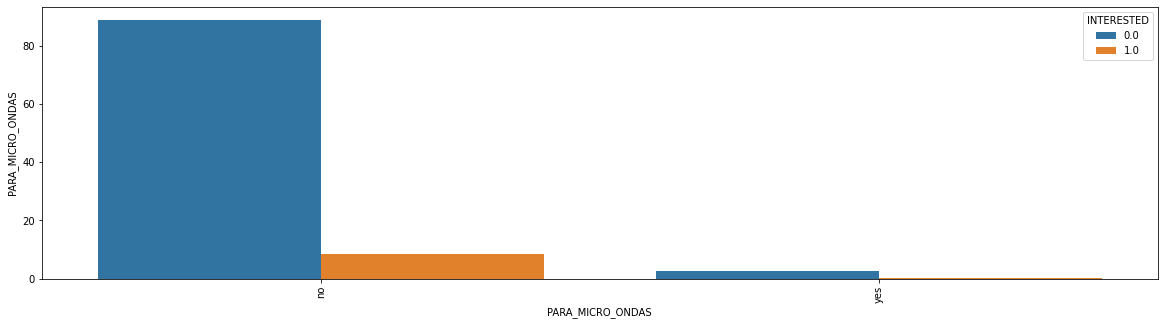

<Figure size 432x288 with 0 Axes>

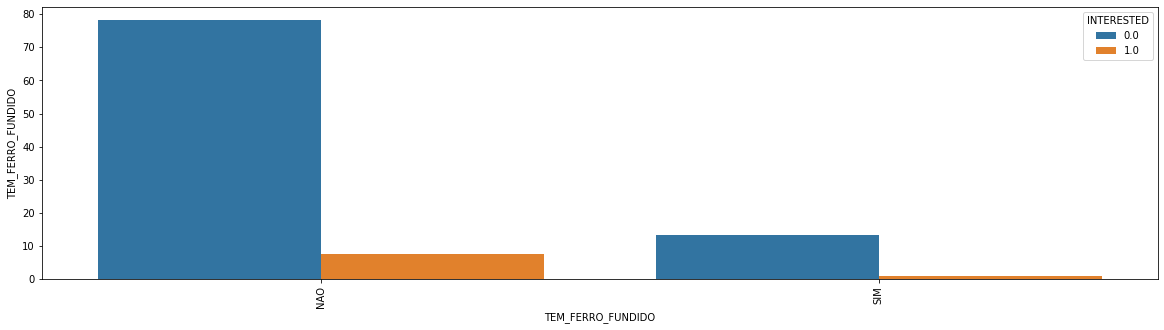

<Figure size 432x288 with 0 Axes>

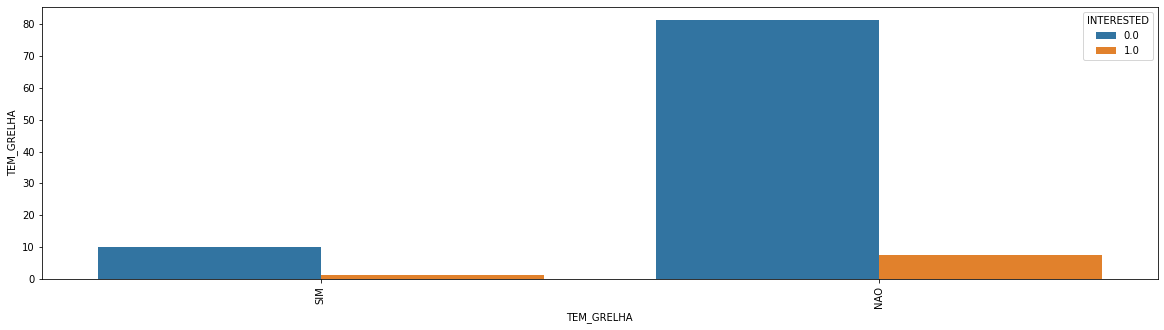

<Figure size 432x288 with 0 Axes>

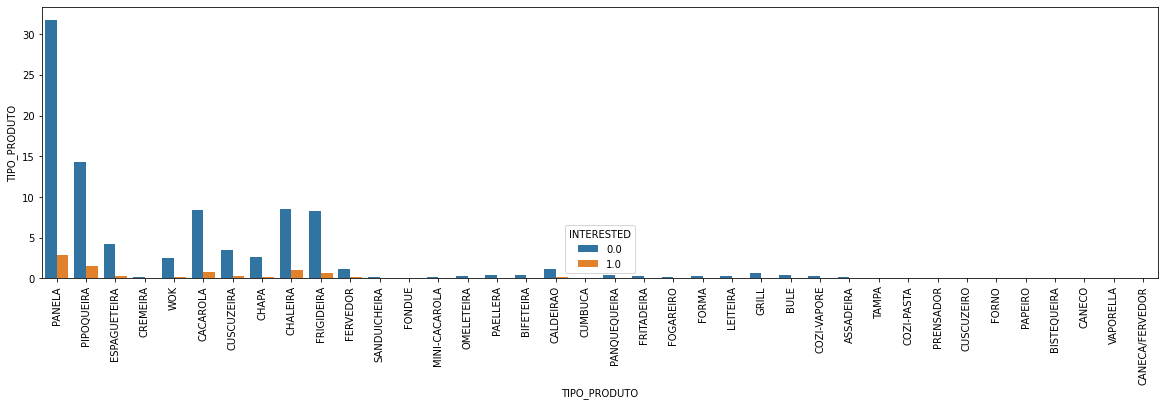

<Figure size 432x288 with 0 Axes>

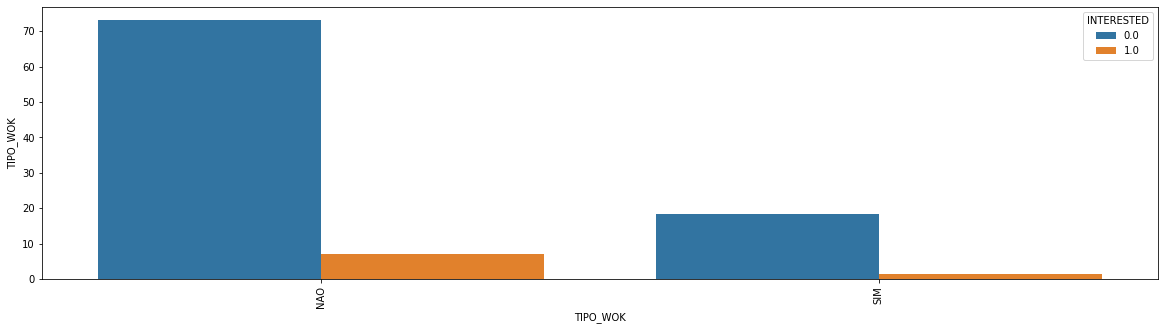

In [23]:
for column in cat_columns:
  plt.figure()
  a4_dims = (20, 5)
  fig, ax = plt.subplots(figsize=a4_dims)
  sns.barplot(x=column, y=column, hue='INTERESTED', data=dataset, orient = 'v', estimator=lambda x: len(x) / len(dataset) * 100)
  locs, labels = plt.xticks()
  plt.setp(labels, rotation=90)

    
    
    

O desbalanceamento de classes interfere na variabilidade desejada na amostra para treino do modelo. Não temos amostra de clientes com interesse em algumas classes de preditores como "Formato" por exemplo.

Será necessária a criação de amostras sintéticas.

Para maior visibilidade das proporções de produtos considerados interessantes, pode ser feita uma média da variável de interesse binária pelas categóricas.

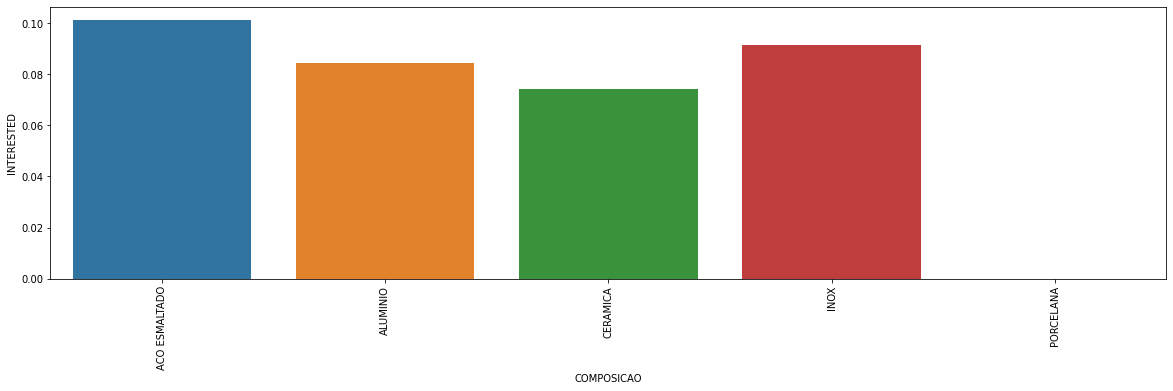

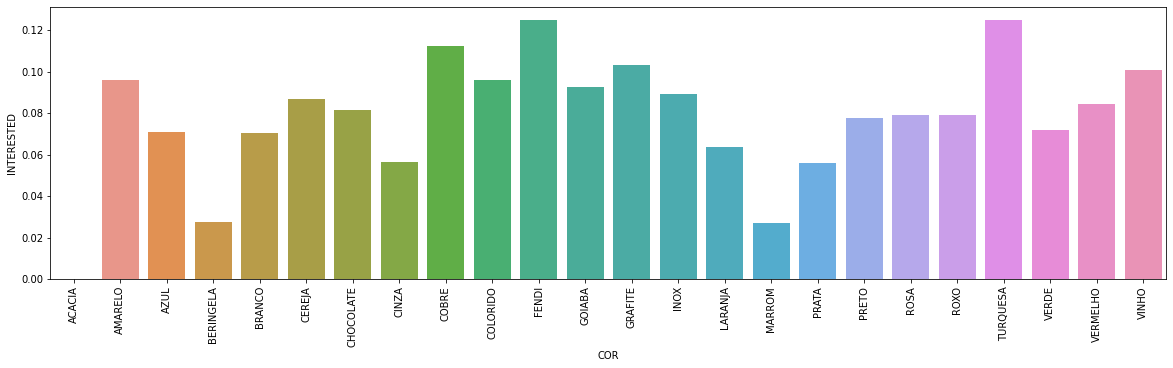

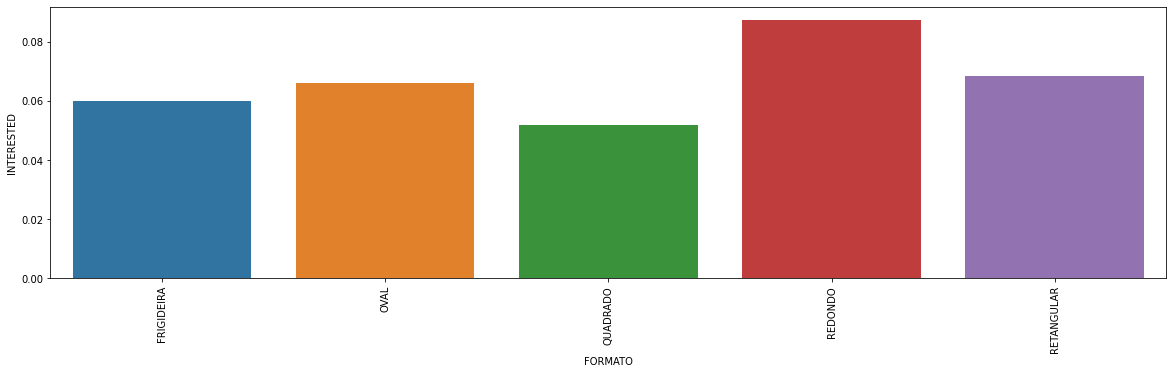

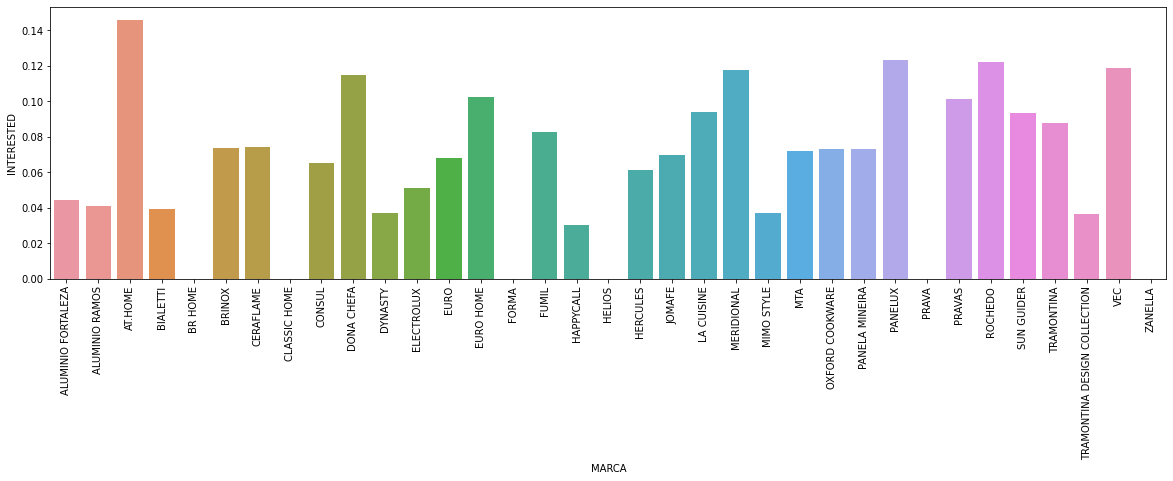

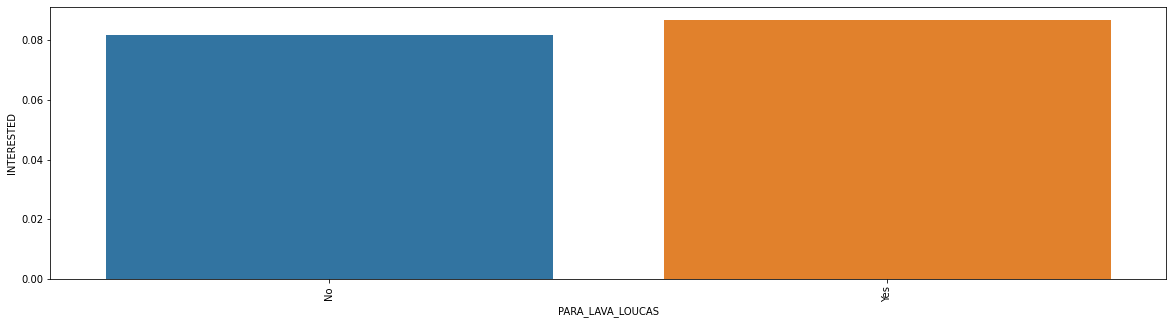

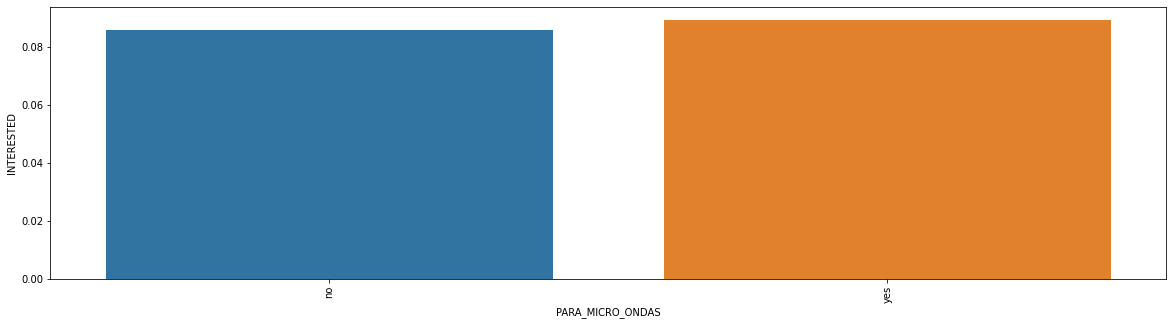

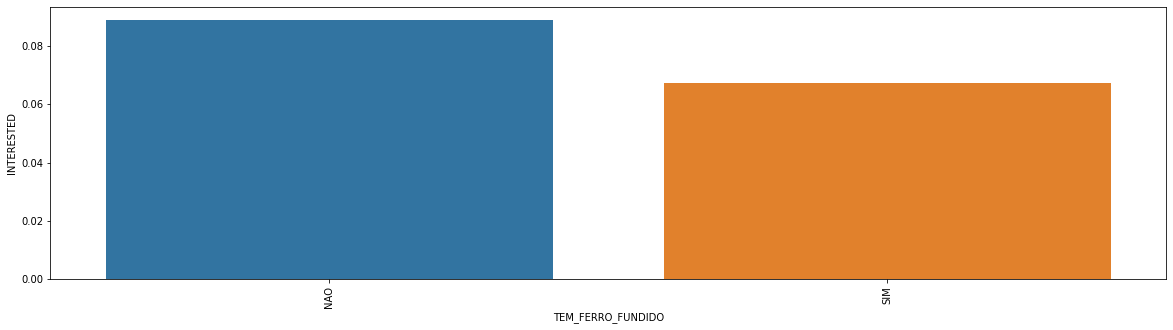

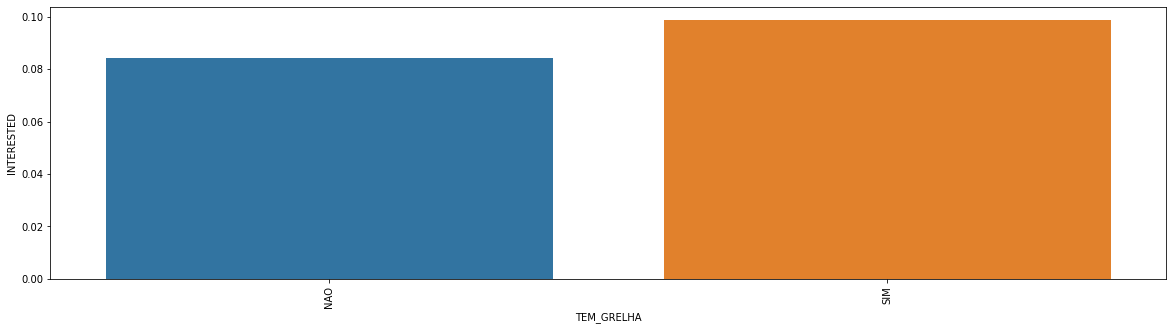

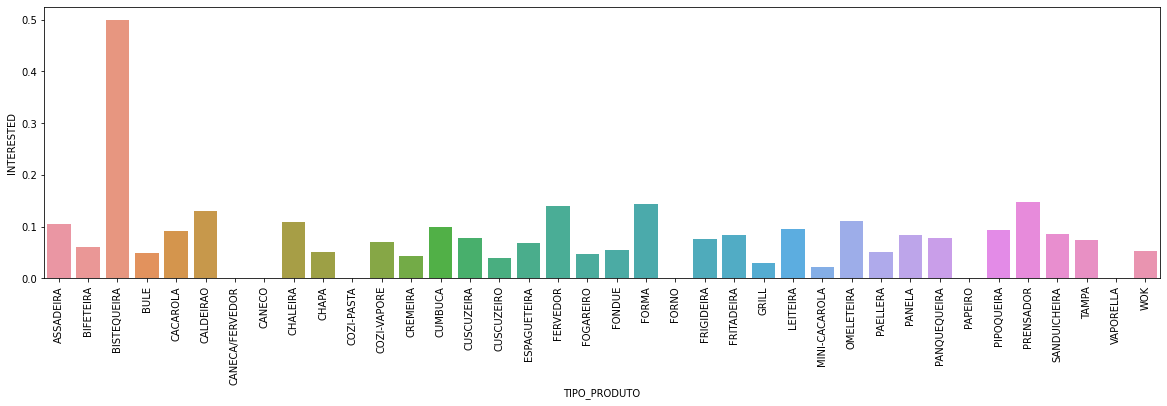

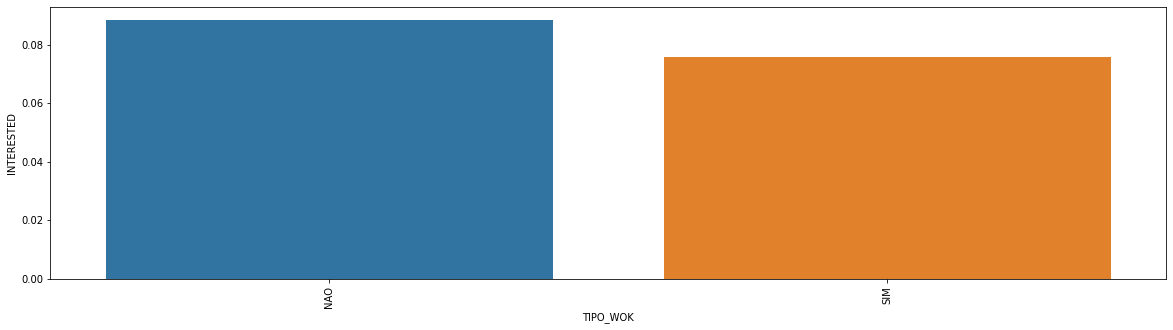

In [24]:
for column in cat_columns:
  avg_cat = dataset[[column,'INTERESTED']].groupby(column, as_index=False).mean()
  a4_dims = (20, 5)
  fig, ax = plt.subplots(figsize=a4_dims)
  sns.barplot(ax=ax, y = 'INTERESTED', x = column, data = avg_cat)
  locs, labels = plt.xticks()
  plt.setp(labels, rotation=90)

## Análise de características do produto
Serão criados 5 grupos com algoritmo K-means para avaliar as variáveis numéricas ref. a características físicas dos produtos: Tamanho, peso, capacidade, etc

In [11]:
data_cluster = dataset[['ALTURA','CAPACIDADE_(L)','LARGURA', 'PESO', 'PROFUNDIDADE']]

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 5, random_state=0).fit(data_cluster)
cluster = kmeans.predict(data_cluster)
data_cluster['cluster'] = cluster
data_cluster.groupby('cluster').count()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ALTURA,CAPACIDADE_(L),LARGURA,PESO,PROFUNDIDADE
cluster,,,,,
0,119110,119110,119110,119110,119110
1,105,105,105,105,105
2,57,57,57,57,57
3,3047,3047,3047,3047,3047
4,11472,11472,11472,11472,11472


Avaliando os agrupamentos criados

In [12]:
medias_cluster = data_cluster.groupby('cluster', as_index=False).mean()
medias_cluster.head()

,cluster,ALTURA,CAPACIDADE_(L),LARGURA,PESO,PROFUNDIDADE
0,0,30.702027,4.444576,28.028631,148.522166,35.117336
1,1,34.000000,4.500000,39.000000,44400.000000,15.000000
2,2,16.982456,3.947368,27.701754,15114.035088,29.228070
3,3,18.208796,3.739777,27.084575,1303.907778,35.713620
4,4,32.908298,3.981817,26.610234,477.877615,33.500549


Clusters 1 e 2 mostram produtos com peso muito acima dos outros grupos

Variável "Capacidade" com pouca variação entre os grupos. Assim como "Profundidade" com exceção dos grupos 1 e 2

Categorizando com base nas médias por cluster

In [13]:
def Cluster(x):
  if x == 0:
    return 'Alta Capacidade Baixo peso'
  if x == 1:
    return 'Outlier peso 1'
  if x == 2:
    return 'Outlier peso 2'
  if x == 3:
    return 'Alto peso Largura inferior'
  if x == 4:
    return 'Alto peso Altura inferior'

dataset['GRUPO_CARACT'] = data_cluster['cluster'].apply(Cluster)

Avaliando a nova variável criada

> Qual o percentual de interesse de acordo com a nova classificação criada?



[None, None, None, None, None, None, None, None, None, None]

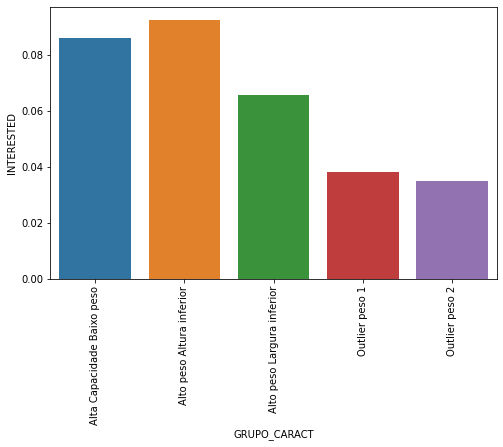

In [14]:
column = 'GRUPO_CARACT'
avg_cat = dataset[[column,'INTERESTED']].groupby(column, as_index=False).mean()
a4_dims = (8, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(ax=ax, y = 'INTERESTED', x = column, data = avg_cat)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

Entre as classes, o cluster com maior proporção de interesse é de alto peso e largura inferior. Pode haver uma associação entre qualidade aqui.

Essa é uma análise qualitativa que mostra como as características do produto afetam de forma diferente o interesse dos clientes.


**Serão testados modelos de classificação para apontar importância das variáveis e gerar scores de interesse**

Valores numéricos serão avaliados novamente após o modelo, para que os fatores sejam isolados

## Preparação para os modelos de classificação + análises complementares

In [15]:
#refazendo o array de colunas devido a inclusão do cluster de características
cat_columns = dataset.select_dtypes('object').columns
#binarizando as categóricas e retirando os ids
dataset_modelo = pd.get_dummies(dataset.drop(id_columns, axis=1), columns=cat_columns)

In [16]:
dataset_modelo.head()

,ALTURA,CAPACIDADE_(L),LARGURA,PESO,PROFUNDIDADE,TEMPO_GARANTIA,TEM_TAMPA,ITEM_PRICE,INTERESTED,COMPOSICAO_ACO ESMALTADO,COMPOSICAO_ALUMINIO,COMPOSICAO_CERAMICA,COMPOSICAO_INOX,COMPOSICAO_PORCELANA,COR_ACACIA,COR_AMARELO,COR_AZUL,COR_BERINGELA,COR_BRANCO,COR_CEREJA,COR_CHOCOLATE,COR_CINZA,COR_COBRE,COR_COLORIDO,COR_FENDI,COR_GOIABA,COR_GRAFITE,COR_INOX,COR_LARANJA,COR_MARROM,COR_PR,COR_PRATA,COR_PRETO,COR_ROSA,COR_ROXO,COR_TURQUESA,COR_VERDE,COR_VERMELHO,COR_VINHO,FORMATO_FRIGIDEIRA,...,TIPO_PRODUTO_CALDEIRAO,TIPO_PRODUTO_CANECA/FERVEDOR,TIPO_PRODUTO_CANECO,TIPO_PRODUTO_CHALEIRA,TIPO_PRODUTO_CHAPA,TIPO_PRODUTO_COZI-PASTA,TIPO_PRODUTO_COZI-VAPORE,TIPO_PRODUTO_CREMEIRA,TIPO_PRODUTO_CUMBUCA,TIPO_PRODUTO_CUSCUZEIRA,TIPO_PRODUTO_CUSCUZEIRO,TIPO_PRODUTO_ESPAGUETEIRA,TIPO_PRODUTO_FERVEDOR,TIPO_PRODUTO_FOGAREIRO,TIPO_PRODUTO_FONDUE,TIPO_PRODUTO_FORMA,TIPO_PRODUTO_FORNO,TIPO_PRODUTO_FRIGIDEIRA,TIPO_PRODUTO_FRITADEIRA,TIPO_PRODUTO_GRILL,TIPO_PRODUTO_LEITEIRA,TIPO_PRODUTO_MINI-CACAROLA,TIPO_PRODUTO_OMELETEIRA,TIPO_PRODUTO_PAELLERA,TIPO_PRODUTO_PANELA,TIPO_PRODUTO_PANQUEQUEIRA,TIPO_PRODUTO_PAPEIRO,TIPO_PRODUTO_PIPOQUEIRA,TIPO_PRODUTO_PRENSADOR,TIPO_PRODUTO_SANDUICHEIRA,TIPO_PRODUTO_TAMPA,TIPO_PRODUTO_VAPORELLA,TIPO_PRODUTO_WOK,TIPO_WOK_NAO,TIPO_WOK_SIM,GRUPO_CARACT_Alta Capacidade Baixo peso,GRUPO_CARACT_Alto peso Altura inferior,GRUPO_CARACT_Alto peso Largura inferior,GRUPO_CARACT_Outlier peso 1,GRUPO_CARACT_Outlier peso 2
0,30.5,4.5,14.0,160.0,50.0,3.0,1.0,199.990000,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,22.0,4.5,24.0,150.0,40.0,12.0,1.0,105.112581,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
2,24.0,4.5,20.0,190.0,20.0,3.0,1.0,139.990000,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,49.5,6.0,41.5,120.0,47.0,6.0,1.0,103.293333,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
4,49.5,6.0,41.5,120.0,47.0,6.0,1.0,103.330242,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0


Array com preditores - base sem o target (campo "INTERESTED")

In [17]:
preditores = dataset_modelo.drop('INTERESTED', axis = 1).columns

Correlações da matriz esparsa

In [55]:
corr2 = dataset_modelo.corr(method='spearman')

In [61]:
for column in preditores:
  temp = corr2[corr2[column] != 1]
  temp = temp[abs(corr2[column]) > 0.55]
  print(column + ": " + temp.index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index(['PESO: GRUPO_CARACT_Alta Capacidade Baixo peso'], dtype='object')
Index([], dtype='object')
Index(['TEMPO_GARANTIA: MARCA_LA CUISINE', 'TEMPO_GARANTIA: MARCA_TRAMONTINA'], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index(['COMPOSICAO_ALUMINIO: COMPOSICAO_INOX', 'COMPOSICAO_ALUMINIO: COR_INOX',
       'COMPOSICAO_ALUMINIO: TIPO_PRODUTO_CHALEIRA'],
      dtype='object')
Index(['COMPOSICAO_CERAMICA: COR_CHOCOLATE', 'COMPOSICAO_CERAMICA: MARCA_CERAFLAME'], dtype='object')
Index(['COMPOSICAO_INOX: COMPOSICAO_ALUMINIO', 'COMPOSICAO_INOX: COR_INOX',
       'COMPOSICAO_INOX: TIPO_PRODUTO_CHALEIRA'],
      dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index(['COR_BERINGELA: MARCA_HAPPYCALL'], dtype='object')
Index([], dtype='object')
Index(['COR_CEREJA: TIPO_WOK_NAO', 'COR_CEREJA: TIPO_WO

A análise acima mostra algumas regras de associação interessantes como por exemplo, os produtos classificados comom outliers de peso do produto estão em linhas ou marcas específicas.

Imports iniciais sklearn

In [18]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

Split base teste e treino - Será reservada 20% da base como validação

In [19]:
x_train, x_test, y_train, y_test = train_test_split(dataset_modelo[preditores]
                                                    , dataset_modelo['INTERESTED']
                                                    , random_state=42, test_size=0.20)

Normalização das variáveis

In [20]:
scaler = StandardScaler()
scaler_model = scaler.fit(x_train)

x_train_scaled = scaler_model.transform(x_train)
x_test_scaled = scaler_model.transform(x_test)


Oversampler para balanceamento

In [21]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = 42)
X_ros, Y_ros = ros.fit_resample(x_train_scaled, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Conferindo o balanceamento de classes da variável INTERESTED

In [22]:
import collections  
count_classes = collections.Counter(Y_ros)
print(count_classes)

Counter({0.0: 97887, 1.0: 97887})


## Modelo Random Forest

O modelo é um tipo de árvore de decisão, que geralmente fornece um bom acerto e lida bem com outliers, por isso será testado inicialmente. A importância das variáveis dará uma pista inicial das investigações a serem feitas para as áreas de negócio.

In [23]:
arvores = [20, 50, 100, 300, 400, 500]
accuracy_array = []

for i in arvores:
  rf = RandomForestClassifier(n_estimators=i)
  rf.fit(X_ros, Y_ros)
  y_predicted_rf = rf.predict(x_test_scaled)
  accuracy_rf = metrics.accuracy_score(y_test, y_predicted_rf).round(4)
  accuracy_array.append(accuracy_rf)


Descobrindo o melhor parâmetro (número de árvores) de acordo com a acurácia usando cross-validation

In [24]:
rf_estimators = pd.DataFrame(list(zip(arvores, accuracy_array)), columns =['arvores', 'acuracia'])
rf_estimators.head(10)

,arvores,acuracia
0,20,0.7090
1,50,0.7108
2,100,0.7091
3,300,0.7091
4,400,0.7092
5,500,0.7091


**Ajustando melhor modelo**

In [25]:
best_rf = RandomForestClassifier(n_estimators= rf_estimators['arvores'][rf_estimators['acuracia'].idxmax()])
best_rf.fit(X_ros, Y_ros)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

**Matriz de confusão**

In [26]:
y_predicted_rf = best_rf.predict(x_test_scaled)

In [27]:
rf_results = pd.DataFrame(list(zip(y_predicted_rf, y_test)), columns = ['predito', 'real'])
df_confusion = pd.crosstab(rf_results.real, rf_results.predito)
df_confusion.head()

predito,0.0,1.0
real,,
0.0,16994,7404
1.0,390,1971


In [28]:
cont = len(rf_results)
#falso negativo e positivo
fp = df_confusion.iloc[0,1]
fn = df_confusion.iloc[1,0]
#verdadeiro (true) positivo e negativo
tp = df_confusion.iloc[1,1]
tn = df_confusion.iloc[0,0]
#recall - taxa de captura de positivos
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)
print(f1)
print(recall)
print(precision)

0.33588957055214724
0.8348157560355781
0.21024


A matriz de confusão mostra que o modelo classifica muitos falsos positivos. Será analisado outro Threshold da probabilidade.

In [29]:
threshold = 0.7

predicted_proba = best_rf.predict_proba(x_test_scaled)
y_predicted_rf = (predicted_proba [:,1] >= threshold).astype('int')
rf_results = pd.DataFrame(list(zip(y_predicted_rf, y_test)), columns = ['predito', 'real'])
df_confusion = pd.crosstab(rf_results.real, rf_results.predito)
df_confusion.head()

predito,0,1
real,,
0.0,21615,2783
1.0,1045,1316


In [30]:
cont = len(rf_results)
#falso negativo e positivo
fp = df_confusion.iloc[0,1]
fn = df_confusion.iloc[1,0]
#verdadeiro (true) positivo e negativo
tp = df_confusion.iloc[1,1]
tn = df_confusion.iloc[0,0]
#recall - taxa de captura de positivos
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)
print(f1)
print(recall)
print(precision)

0.4074303405572755
0.5573909360440491
0.32105391558916807


Definindo-se que produtos com score acima de 70% serão classificados como de interesse, é verificado um melhor equilíbrio entre os acertos de casos positivos e negativos, e conseguimos diminuir a taxa de falsos positivos. O score F1, que leva em consideração essas duas métricas atinge valor de 40% mostrando que não é um modelo com acerto ideal.

Nesse momento é importante avaliar o risco ou custo de se classificar um produto como falso positivo ou negativo.

Também poderá ser necessário coletar mais dados (características dos clientes que geraram os eventos ou mais registros com o tempo, ou ainda ou experimentos randomizados) para chegar a conclusões mais confiáveis sobre o interesse dos produtos.

**Levantando a importância das variáveis**

Mesmo com o modelo não estando com acerto ideal faremos análise da importancia das variáveis como exercício. O objetivo é gerar entendimento sobre os fatores que despertam interesse nos clientes 

In [31]:
importance_df = pd.DataFrame(best_rf.feature_importances_, columns = ['importancia'], index = preditores)

In [32]:
importance_df.sort_values(by='importancia', ascending=False).head(16)

,importancia
ITEM_PRICE,0.836751
LARGURA,0.017875
ALTURA,0.016496
PROFUNDIDADE,0.015845
PESO,0.009765
CAPACIDADE_(L),0.006987
TEM_TAMPA,0.005631
TEMPO_GARANTIA,0.004496
COR_VERMELHO,0.003261
COR_COLORIDO,0.003003



**O preço é um preditor muito forte de interesse. Para avaliar as outras features é necessário retira-la.**

Top 15 features ordenadas pela importância, retirando preço

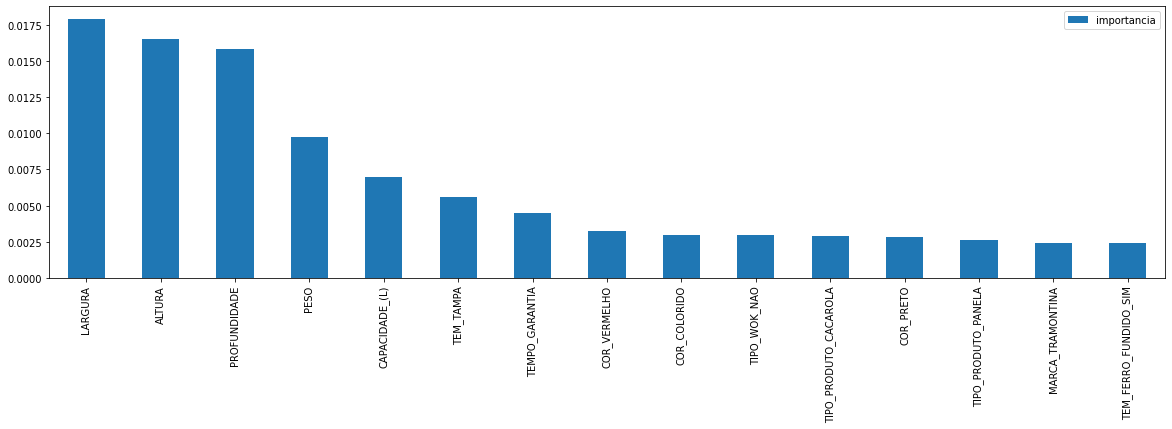

In [33]:
importance_df[importance_df.index != 'ITEM_PRICE'].sort_values(by='importancia', ascending=False).head(15).plot.bar(figsize=(20,5))

## Conclusões importantes - Insights

O gráfico de importância de variáveis na random forest aponta preditores importantes, como por exemplo:

*   Informações físicas como: Profundidade, Altura, Largura, Peso e Capacidade.  

*   A informação se o produto tem tampa 

*   Alguns tipos de panela

*   Algumas cores se destacaram como importantes para predição de interesse

* Indicador se o produto é Wok

* Marca Tramontina

Importante destacar que aqui está sendo avaliado o peso da informação mas não se a característica indica maior ou menor interesse, que é o próximo passo.

### **Investigando os preditores para gerar insights para a áreas de  negócio**

In [34]:
features_importantes = importance_df.sort_values(by='importancia', ascending=False).head(15).index

Gráficos para melhor entendimento - distribuição ou taxa de interesse por valor da variável 

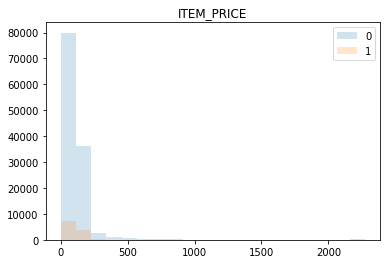

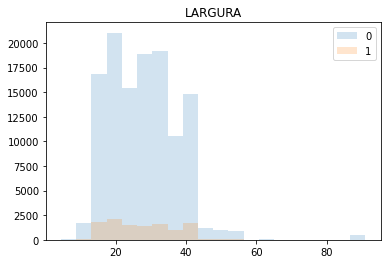

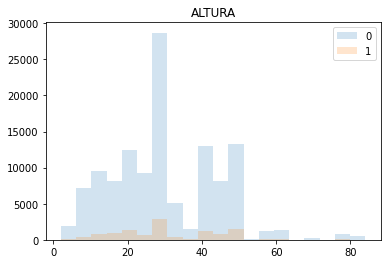

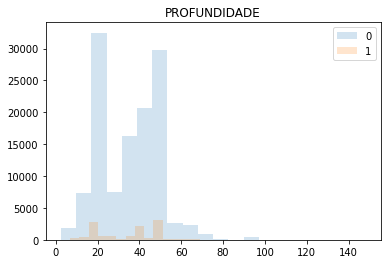

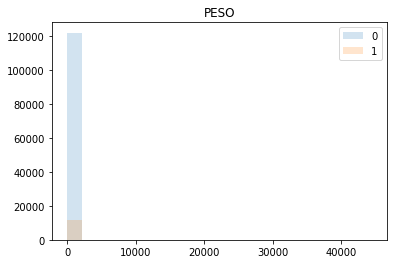

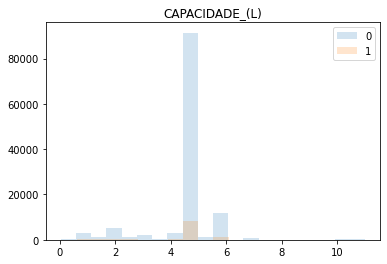

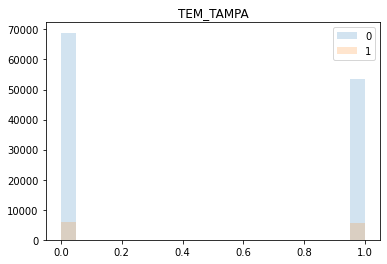

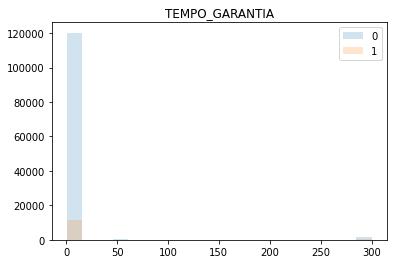

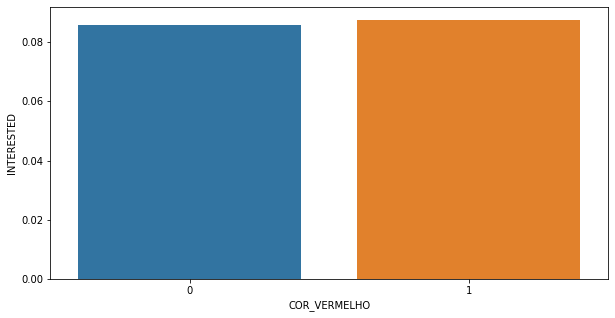

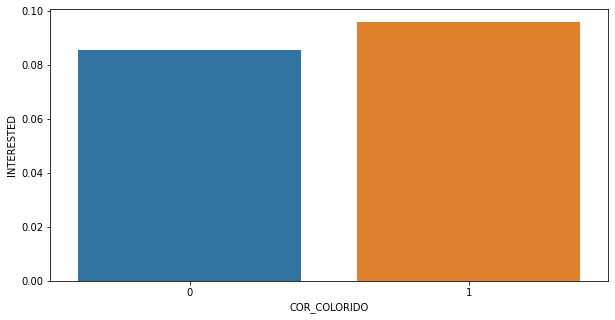

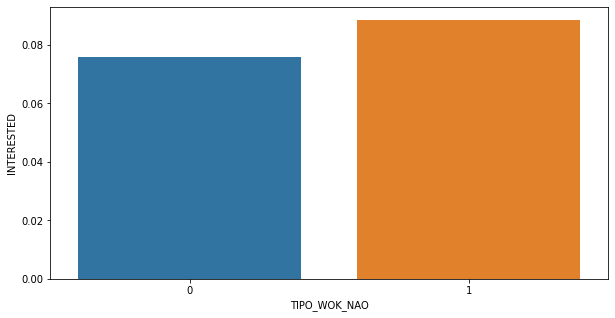

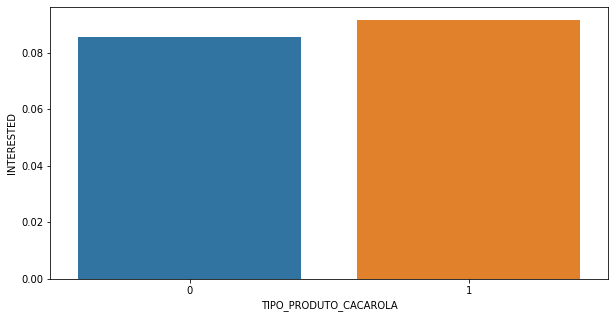

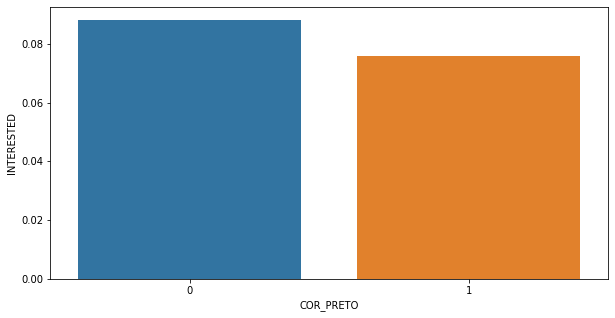

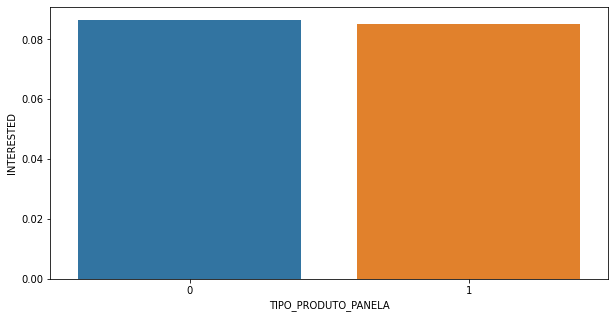

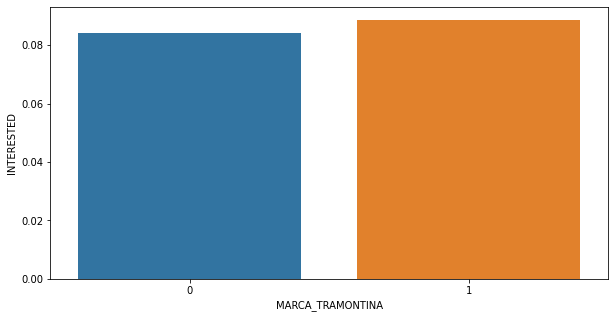

In [35]:
for column in features_importantes:
    
    if dataset_modelo[column].dtype != 'float64': 
      
      avg_cat = dataset_modelo[[column,'INTERESTED']].groupby(column, as_index=False).mean()
      a4_dims = (10, 5)
      fig, ax = plt.subplots(figsize=a4_dims)
      sns.barplot(ax=ax, y = 'INTERESTED', x = column, data = avg_cat)
    
    if dataset_modelo[column].dtype == 'float64': 
      
      #plt.scatter(dataset_modelo['INTERESTED'], dataset_modelo[column])
      plt.hist(dataset_modelo[dataset_modelo['INTERESTED'] == 0][column], bins = 20, alpha = 0.2, label='0')
      plt.hist(dataset_modelo[dataset_modelo['INTERESTED'] == 1][column], bins = 20, alpha = 0.2, label='1')
      plt.legend(loc='upper right')
      plt.title(column)
      plt.show()


Tempo de garantia é ordinal. Investigar essa feature de outra forma:

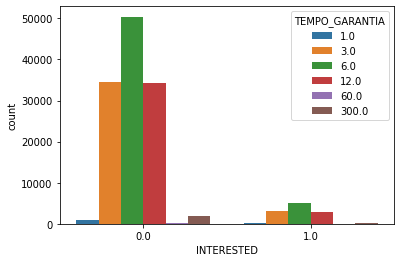

In [36]:
sns.countplot(x='INTERESTED', hue='TEMPO_GARANTIA', data=dataset_modelo)

**Heurísticas de negócio:**

* Interesse é concentrado em itens com preço até R$ 250

* Não foi detectado interesse significativo em produtos com as características:
com profundidade, altura ou largura acima de 50

* Capacidade com mais taxa de interesse na faixa entre 4-5L e também produtos com tampa

* A combinação de características (vide análise de características do produto) com maior taxa de interesse é "Alto peso, largura inferior"
seguido de "Alta capacidade, baixo peso". As médias dos clusters dão um indício dos limites de forma mais precisa.

* A proporção de garantia de 6 meses é bem menor dentre os clientes com interesse, porém não foi detectada relação linear (não desperta mais interesse por ter tempo de garantia maior)

* Tipo Wok=Não com mais taxa de interesse

* Cor preta com taxa de interesse menor e colorido com interesse maior

* Produtos do tipo Caçarola despertam maior interesse

* Marca Tramontina mostra um maior interesse

## Modelo de Regressão Logística

Uma abordagem pode ser a utilização de um modelo estatístico tradicional. Os coeficientes fornecem tanto importância quanto relacionamento (direto ou inverso) e magnitude. 

A biblioteca statsmodel oferece um sumário bem completo.

In [52]:
formula_text = ("""
    INTERESTED ~ 
    ITEM_PRICE
    + PROFUNDIDADE
    + ALTURA
    + LARGURA
    + PESO
    + CAPACIDADE	
    + TEM_TAMPA
    + TEMPO_GARANTIA	
    + COR_VERMELHO
    + TIPO_WOK_NAO
    + TIPO_PRODUTO_CACAROLA
    + TIPO_WOK_SIM
    + COR_PRETO
    + TIPO_PRODUTO_PANELA
    + MARCA_TRAMONTINA	
    + COR_COLORIDO
    """)

In [53]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
#utilizando o dataset sem normalização
dataset_modelo['CAPACIDADE'] = dataset_modelo['CAPACIDADE_(L)']
logit_model = smf.logit(formula = str(formula_text), data = dataset_modelo).fit()
print(logit_model.summary2())

         Current function value: 0.291575
         Iterations: 35


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.005     
Dependent Variable:    INTERESTED        AIC:               78052.1735
Date:                  2020-08-24 20:31  BIC:               78209.0381
No. Observations:      133791            Log-Likelihood:    -39010.   
Df Model:              15                LL-Null:           -39225.   
Df Residuals:          133775            LLR p-value:       2.6040e-82
Converged:             0.0000            Scale:             1.0000    
No. Iterations:        35.0000                                        
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
Intercept             -1.6353      nan      nan    nan     nan     nan
ITEM_PRICE            -0.0015   0.0001 -14.9868 0.0000 -0.0017 -0.0013
PROFUNDIDADE          -0.0044     

Inferimos que a cada R$ 100 de acréscimo no preço, a chance do produto captar interesse cai 15% (aproximadamente).

As cores vermelha e preta tem chance menor de gerar interesse em relação as outras cores (6% e 16% respectivamente).

Produto Panela e Caçarola tem maior chance (20% e 18% respectivamente).

Marca Tramontina com 6% mais chance de atrair interesse.
Produtos com tampa tem chance 16% maior.


Verificando acurácia do modelo de regressão logística do Sci-kit learn. Será utilizada essa biblioteca devido a aproveitamento do código.

In [39]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_ros, Y_ros)
y_predicted_lr = lr.predict(x_test_scaled)
accuracy_lr = metrics.accuracy_score(y_test, y_predicted_lr).round(4)


In [49]:
print(accuracy_lr)

0.5199


In [40]:
results = pd.DataFrame(list(zip(y_predicted_lr, y_test)), columns = ['predito', 'real'])
df_confusion = pd.crosstab(results.real, results.predito)
df_confusion.head()

predito,0.0,1.0
real,,
0.0,12441,11957
1.0,889,1472


In [41]:
cont = len(results)
#falso negativo e positivo
fp = df_confusion.iloc[0,1]
fn = df_confusion.iloc[1,0]
#verdadeiro (true) positivo e negativo
tp = df_confusion.iloc[1,1]
tn = df_confusion.iloc[0,0]
#recall - taxa de captura de positivos
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)
print(f1)
print(recall)
print(precision)

0.1864471184293857
0.6234646336298179
0.10961352297267109


### Outros modelos
Serão feitos outros testes com modelos de ML para melhoria da acurácia 

## Modelo SVM

In [42]:
svm_clf = svm.SVC()
svm_clf.fit(X_ros, Y_ros)
y_predicted_svm = svm_clf.predict(x_test_scaled)
accuracy_svm = metrics.accuracy_score(y_test, y_predicted_svm).round(3)
print(accuracy_svm)

0.514


In [43]:
results = pd.DataFrame(list(zip(y_predicted_svm, y_test)), columns = ['predito', 'real'])
df_confusion = pd.crosstab(results.real, results.predito)
df_confusion.head()

predito,0.0,1.0
real,,
0.0,12226,12172
1.0,833,1528


In [44]:
cont = len(results)
#falso negativo e positivo
fp = df_confusion.iloc[0,1]
fn = df_confusion.iloc[1,0]
#verdadeiro (true) positivo e negativo
tp = df_confusion.iloc[1,1]
tn = df_confusion.iloc[0,0]
#recall - taxa de captura de positivos
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)
print(f1)
print(recall)
print(precision)

0.1902745781707241
0.6471833968657349
0.11153284671532847


## Multilayer Perceptron

In [45]:
clf_mlp1 = MLPClassifier(solver='sgd'
                     , hidden_layer_sizes= 20
                     , max_iter = 1000
                     , random_state=1)

clf_mlp1.out_activation_ = 'softmax'

In [46]:
clf_mlp1.fit(X_ros, Y_ros)
y_predicted_mlp1 = clf_mlp1.predict(x_test_scaled)
print(metrics.accuracy_score(y_test, y_predicted_mlp1).round(4))

0.4094


In [47]:
results = pd.DataFrame(list(zip(y_predicted_mlp1, y_test)), columns = ['predito', 'real'])
df_confusion = pd.crosstab(results.real, results.predito)
df_confusion.head()

predito,0.0,1.0
real,,
0.0,9099,15299
1.0,504,1857


In [48]:
cont = len(results)
#falso negativo e positivo
fp = df_confusion.iloc[0,1]
fn = df_confusion.iloc[1,0]
#verdadeiro (true) positivo e negativo
tp = df_confusion.iloc[1,1]
tn = df_confusion.iloc[0,0]
#recall - taxa de captura de positivos
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)
print(f1)
print(recall)
print(precision)

0.1902956396987242
0.7865311308767471
0.10824201445558405


## Teste SMOTE com Random Forest

In [62]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)
X_smt, Y_smt = smote.fit_resample(x_train_scaled, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [63]:
rf2 = RandomForestClassifier(n_estimators=50)
rf2.fit(X_smt, Y_smt)
y_predicted_rf2 = rf2.predict(x_test_scaled)
accuracy_rf2 = metrics.accuracy_score(y_test, y_predicted_rf2).round(4)
print(accuracy_rf2)

0.7343


In [64]:
results = pd.DataFrame(list(zip(y_predicted_rf2, y_test)), columns = ['predito', 'real'])
df_confusion = pd.crosstab(results.real, results.predito)
df_confusion.head()

predito,0.0,1.0
real,,
0.0,17787,6611
1.0,498,1863


In [65]:
cont = len(results)
#falso negativo e positivo
fp = df_confusion.iloc[0,1]
fn = df_confusion.iloc[1,0]
#verdadeiro (true) positivo e negativo
tp = df_confusion.iloc[1,1]
tn = df_confusion.iloc[0,0]
#recall - taxa de captura de positivos
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)
print(f1)
print(recall)
print(precision)


0.3438855560682972
0.7890724269377383
0.21984894972858154


In [66]:
threshold = 0.7

predicted_proba = rf2.predict_proba(x_test_scaled)
y_predicted_rf2 = (predicted_proba [:,1] >= threshold).astype('int')
results = pd.DataFrame(list(zip(y_predicted_rf2, y_test)), columns = ['predito', 'real'])
df_confusion = pd.crosstab(results.real, results.predito)
df_confusion.head()

predito,0,1
real,,
0.0,22021,2377
1.0,1114,1247


In [67]:
cont = len(results)
#falso negativo e positivo
fp = df_confusion.iloc[0,1]
fn = df_confusion.iloc[1,0]
#verdadeiro (true) positivo e negativo
tp = df_confusion.iloc[1,1]
tn = df_confusion.iloc[0,0]
#recall - taxa de captura de positivos
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)
print(f1)
print(recall)
print(precision)


0.41670843776106936
0.5281660313426514
0.34409492273730685


## Conclusões gerais Modelos / Melhorias

Entre os modelos testados a melhor performance foi da Random Forest, treinada com a técnica SMOTE.
No entanto é preciso mais informações a fim de predizer interesse nos produtos de forma mais precisa. No entanto, o modelo performa bem para detectar os produtos que não despertam interesse. Se o objetivo é equilíbrio entre o acerto de positivos e negativos o threshold ideal é 70%.

Uma métrica que poderia acrescentar informações relevantes sobre o acerto do modelo seria o Ks, pois ajuda a determinar o limite ótimo do score para classificar o interesse.

Uma outra estratégia para melhoria do acerto pode ser *feature engineering*: Utilizar outras funções de binarização, outras funções de transformação nas variáveis numéricas e ainda inclusão de variáveis de interações. Podem haver interações não investigadas entre características de produtos e marcas que podem deixar as heurísticas de negócio mais objetivas.

Outros modelos podem ser testados como: Knn, Redes Neurais (LSTM por exemplo), SVM com outras funções Kernel. 